In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
raw_data = pd.read_csv("/content/drive/MyDrive/Major Project 8th sem/Code/data/IBM_2years_15Min.csv")

In [5]:
print(raw_data.shape)
raw_data.head()

(21535, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2020-04-20 04:15:00,103.594936,103.594936,103.594936,103.594936,410
1,1,2020-04-20 05:00:00,103.828024,103.828024,103.828024,103.828024,104
2,2,2020-04-20 06:00:00,103.560404,103.560404,103.335948,103.335948,927
3,3,2020-04-20 06:30:00,102.826607,103.327315,102.723012,103.327315,629
4,4,2020-04-20 07:15:00,103.422277,103.422277,102.731645,102.731645,1117


In [6]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

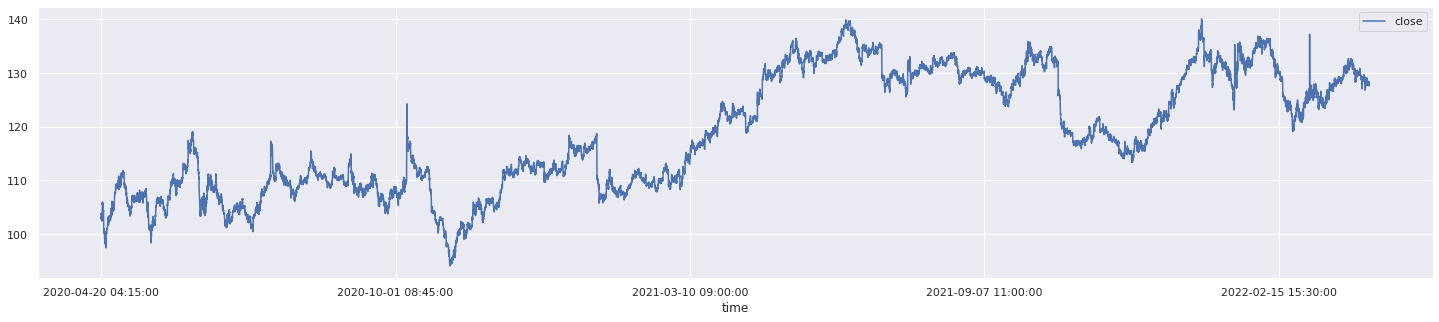

In [7]:
close_ds.plot(x='time', y='close', figsize=(25, 5))

In [8]:
# converting time serires into a supervised learning problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [30]:
# n_in ---> number of previous data points (lag observations) to consider as input
# n_out --> number of datapoints to predict
# dataset ----> dataframe with (n_in + n_out + 1 [for current timestamp]) numbers of columns used for supervised training of the model 

n_in = 50
n_out = 40
dataset = series_to_supervised(close_ds.drop('time', axis=1), n_in, n_out)
print(dataset.shape)
dataset.head()

(21445, 52)


,close(t-50),close(t-49),close(t-48),close(t-47),close(t-46),close(t-45),close(t-44),close(t-43),close(t-42),close(t-41),...,close(t-8),close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1),close(t),close(t+40)
50,103.594936,103.828024,103.335948,103.327315,102.731645,103.240986,102.774809,102.723012,102.990632,102.990632,...,102.645315,102.533088,101.307214,100.797872,100.098607,100.098607,100.737442,100.616581,100.702824,100.461189
51,103.828024,103.335948,103.327315,102.731645,103.240986,102.774809,102.723012,102.990632,102.990632,102.558986,...,102.533088,101.307214,100.797872,100.098607,100.098607,100.737442,100.616581,100.702824,100.918733,99.904366
52,103.335948,103.327315,102.731645,103.240986,102.774809,102.723012,102.990632,102.990632,102.558986,102.394961,...,101.307214,100.797872,100.098607,100.098607,100.737442,100.616581,100.702824,100.918733,100.875569,100.081341
53,103.327315,102.731645,103.240986,102.774809,102.723012,102.990632,102.990632,102.558986,102.394961,102.731645,...,100.797872,100.098607,100.098607,100.737442,100.616581,100.702824,100.918733,100.875569,100.616581,100.374860
54,102.731645,103.240986,102.774809,102.723012,102.990632,102.990632,102.558986,102.394961,102.731645,103.128758,...,100.098607,100.098607,100.737442,100.616581,100.702824,100.918733,100.875569,100.616581,100.530252,100.728809


In [31]:
# train test split

from sklearn.model_selection import train_test_split
target = dataset.loc[:, ['close(t+40)']]
features = dataset.drop('close(t+40)', axis=1)
print(target.shape)
print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21445, 1)
(21445, 51)
(15011, 51)
(15011, 1)
(6434, 51)
(6434, 1)


In [32]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# Multilayer perceptron 

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               5200      
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
mlp_history = model_mlp.fit(X_train.values, y_train.values, validation_data=(X_test.values, y_test.values), epochs=40, verbose=2)

Epoch 1/40
470/470 - 1s - loss: 81.5151 - val_loss: 5.1382 - 1s/epoch - 3ms/step
Epoch 2/40
470/470 - 1s - loss: 5.0853 - val_loss: 4.9200 - 887ms/epoch - 2ms/step
Epoch 3/40
470/470 - 1s - loss: 5.0404 - val_loss: 4.8813 - 751ms/epoch - 2ms/step
Epoch 4/40
470/470 - 1s - loss: 5.0089 - val_loss: 4.6455 - 777ms/epoch - 2ms/step
Epoch 5/40
470/470 - 1s - loss: 5.0406 - val_loss: 4.4576 - 825ms/epoch - 2ms/step
Epoch 6/40
470/470 - 1s - loss: 4.7715 - val_loss: 5.8388 - 816ms/epoch - 2ms/step
Epoch 7/40
470/470 - 1s - loss: 4.7951 - val_loss: 6.2037 - 788ms/epoch - 2ms/step
Epoch 8/40
470/470 - 1s - loss: 4.7554 - val_loss: 4.1172 - 867ms/epoch - 2ms/step
Epoch 9/40
470/470 - 1s - loss: 4.6977 - val_loss: 4.0205 - 918ms/epoch - 2ms/step
Epoch 10/40
470/470 - 1s - loss: 4.5326 - val_loss: 8.4508 - 883ms/epoch - 2ms/step
Epoch 11/40
470/470 - 1s - loss: 4.5229 - val_loss: 7.8262 - 774ms/epoch - 2ms/step
Epoch 12/40
470/470 - 1s - loss: 4.6391 - val_loss: 6.2765 - 895ms/epoch - 2ms/step
Epo

Text(0, 0.5, 'MSE')

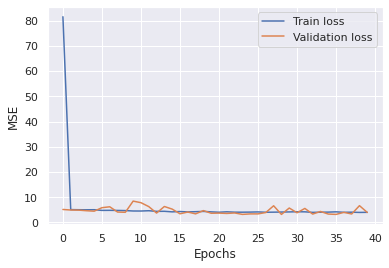

In [34]:
# plots 
fig = plt.figure()
plt.plot(mlp_history.history['loss'], label='Train loss')
plt.plot(mlp_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [35]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
mlp_train_pred = model_mlp.predict(X_train)
mlp_test_pred = model_mlp.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, mlp_test_pred)))

Train rmse: 2.01377128449188
Validation rmse: 1.9881755130468783


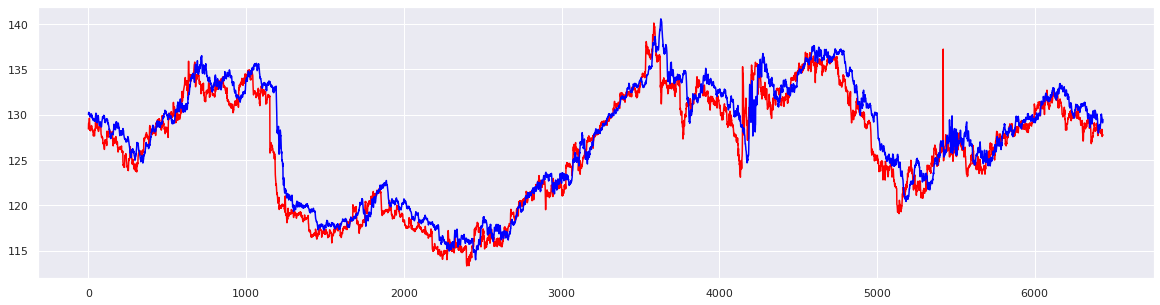

In [39]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True), color='red')
plt.plot(mlp_test_pred, color='blue')
plt.show()